Импорт основных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Считываем все нужные таблицы

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


Сортируем датасет, чтобы лаги были корректными

In [4]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


Размер Датасета

In [5]:
df.shape

(400, 2)

нулевых значений нет

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


# Проверка на стационарность, авторкорреляцию

<Axes: ylabel='Цена на арматуру'>

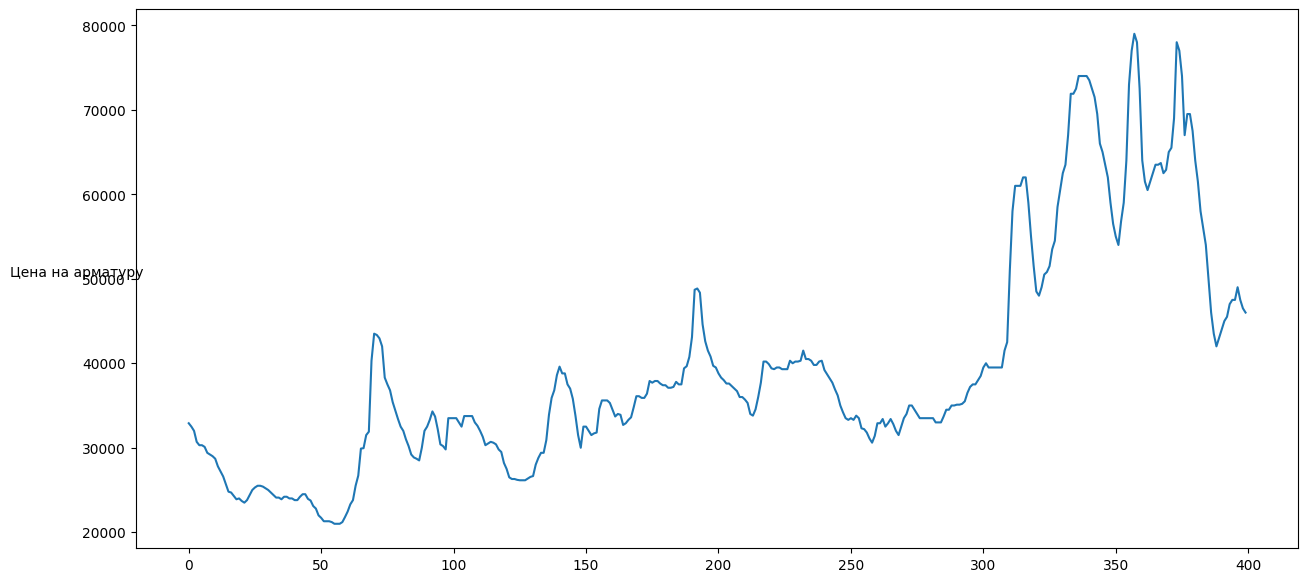

In [7]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [8]:
!pip install statsmodels==0.14.4

In [9]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


Отсюда можем взять стат.характеристика как признаки для модели

In [10]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [11]:
df['Цена на арматуру'].describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [12]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты: тренд, сезоннотсь, шум, и оригинальные данные

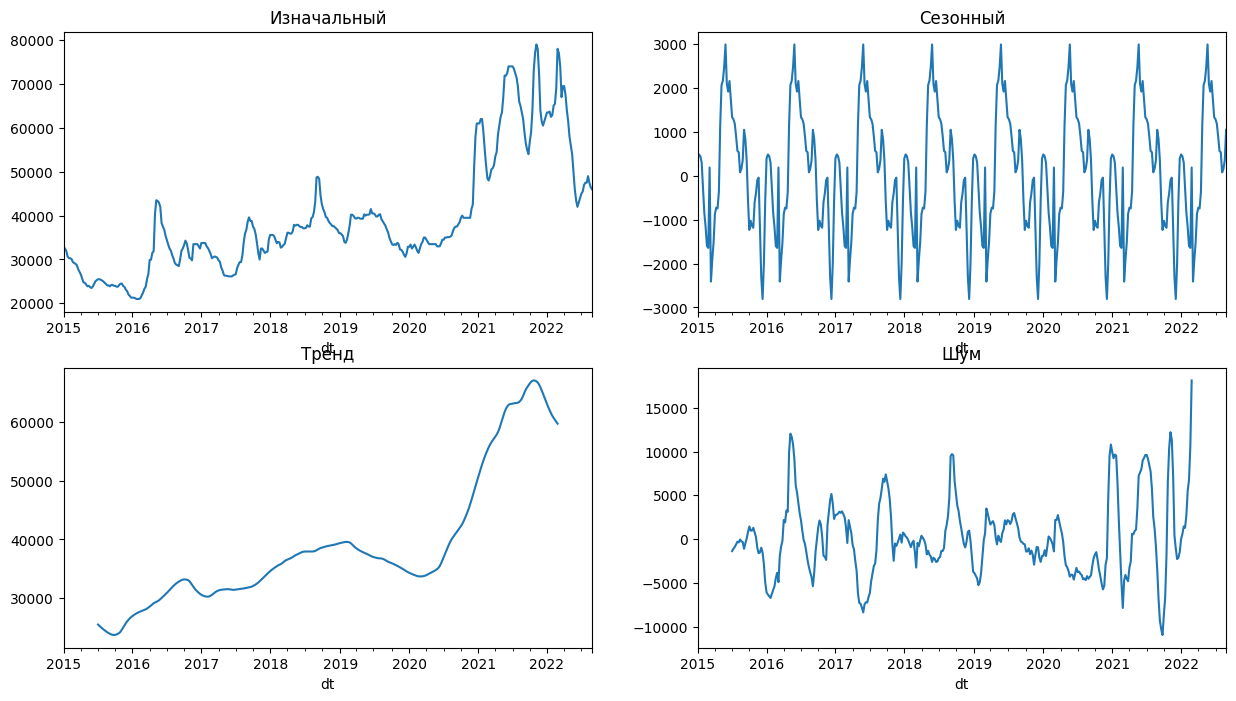

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


Снова раскладываем на компоненты и сохраняем в датасет как признак

In [14]:
from statsmodels.tsa.seasonal import STL

values = np.sin(np.linspace(0, 40, 400)) * 10 + np.arange(400)
data = pd.Series(values, index=df['Цена на арматуру'])

decomposition = STL(df, seasonal=13).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
df['trend'] = trend
df['season'] = seasonal

**Тест на стационарность**

можно предположить, т.к. p > 0.05, что временной ряд нестационарен

In [15]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


**Автокорреляция и частичная автокорреляция**

Здесь мы можем увидеть важные лаги - те, которые не входят в закрашенную область

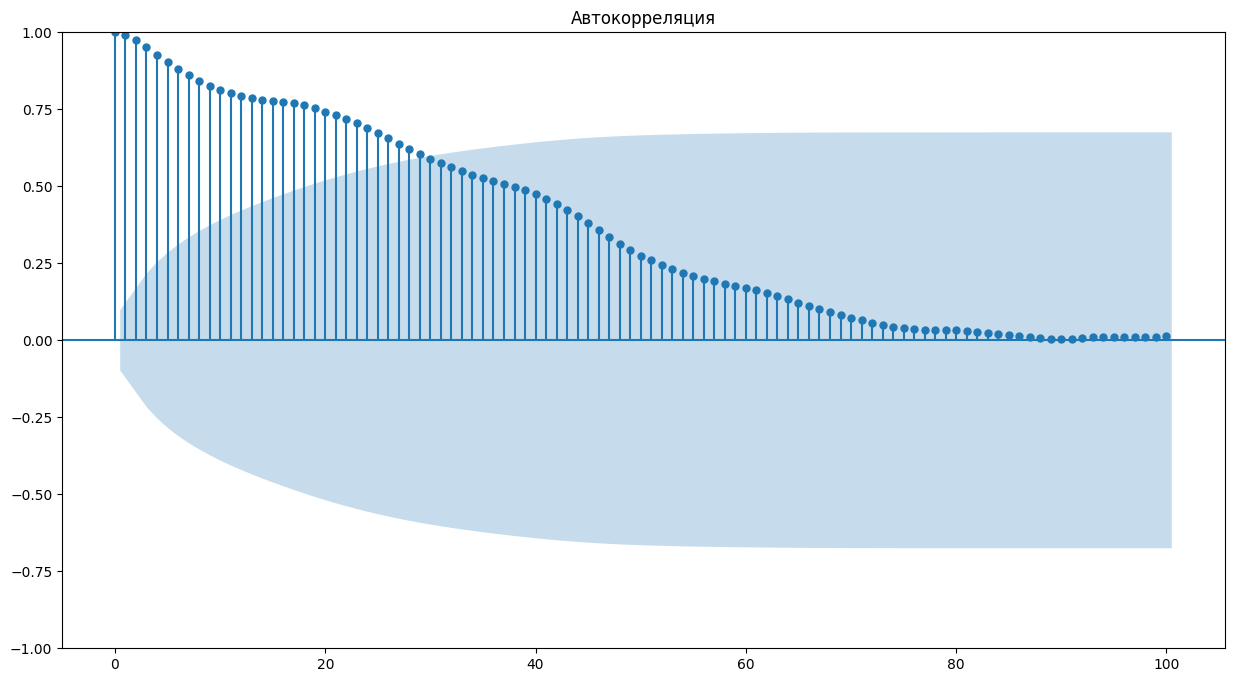

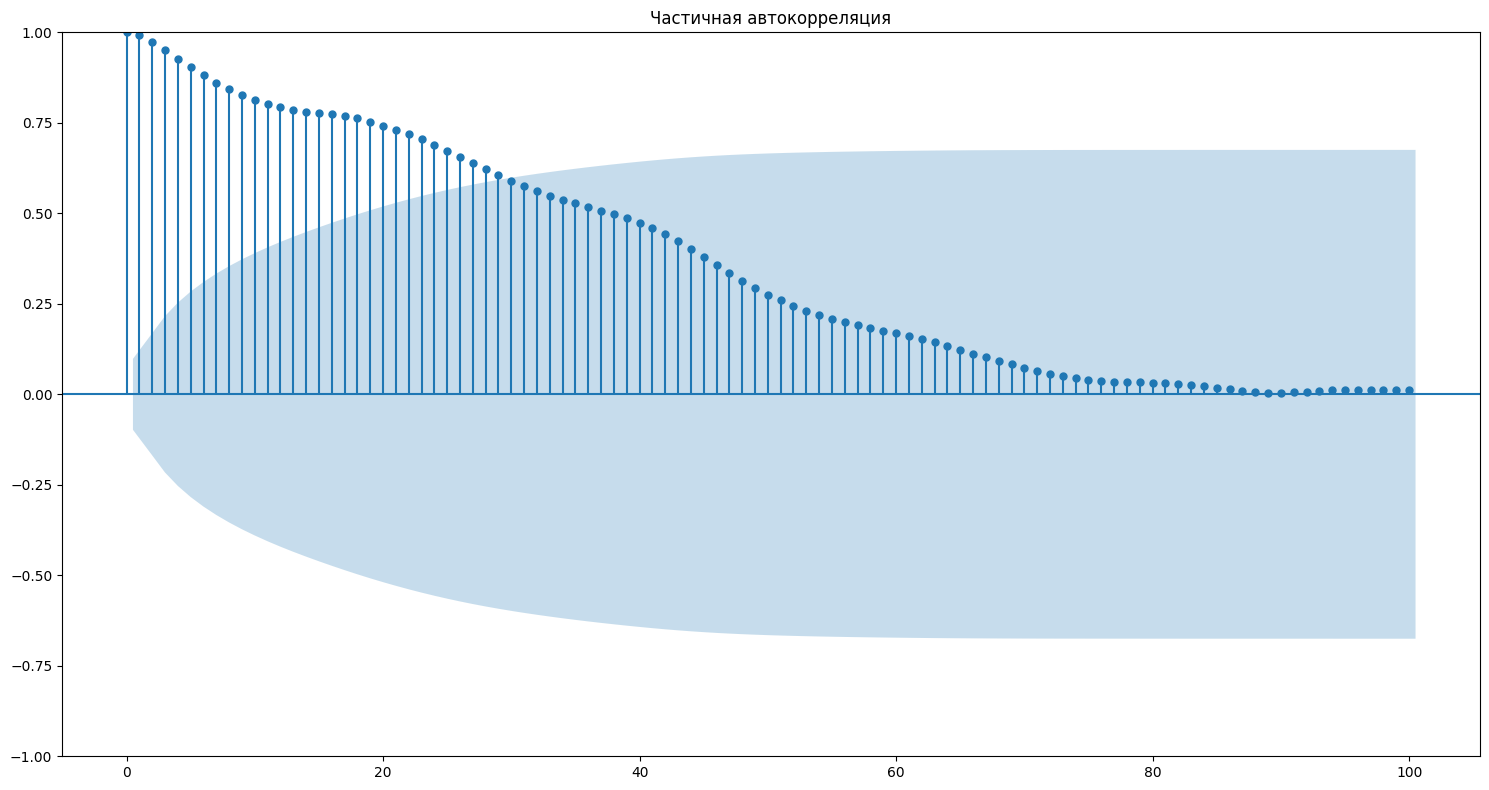

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Основные 25 лагов не входят в закрашенный промежток, значит значение из этого диапазона можно использовать как признаки для модели

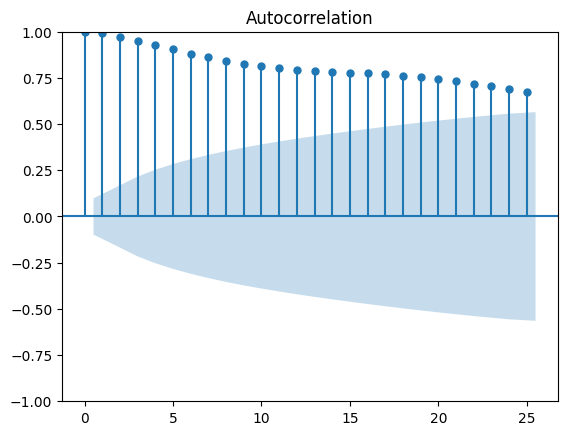

In [17]:
plot_acf(df['Цена на арматуру'], lags=25)
plt.show()

Можно добавить скользящее среднее как признак, чтобы сгладить временной ряд

In [18]:
# df['Цена_Smooth_52'] = df['Цена на арматуру'].rolling(window=7, center=True).mean()

# Преобразование временного ряда в стационарный

Надо сделать стационарный временной ряд, и использовать его как признак при обучении модели


Сезонное дифференцирование, выбираем период 7

In [19]:
# df['Цена_seasonal_diff'] = (df['Цена на арматуру']).diff(periods=)

In [20]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.1 MB/s eta 0:00:00


Лаги


In [21]:
df['lag_1'] = df['Цена на арматуру'].shift(1)
df['lag_2'] = df['Цена на арматуру'].shift(2)
df['lag_3'] = df['Цена на арматуру'].shift(3)
df['lag_4'] = df['Цена на арматуру'].shift(4)
df['lag_52'] = df['Цена на арматуру'].shift(52)


Временные признаки

In [22]:
window = 7
df['rolling_mean'] = df['Цена на арматуру'].rolling(window=window).mean()
df['rolling_std'] = df['Цена на арматуру'].rolling(window=window).std()
df['rolling_min'] = df['Цена на арматуру'].rolling(window=window).min()
df['rolling_max'] = df['Цена на арматуру'].rolling(window=window).max()
df['rolling_range'] = df['rolling_max'] - df['rolling_min']

# # коэффициент вариации
df['coef_of_variation'] = df['rolling_std'] / df['rolling_mean']

# интерквартильный размах (пример для 25% и 75%)
df['rolling_25%'] = df['Цена на арматуру'].rolling(window=window).quantile(0.25)
df['rolling_75%'] = df['Цена на арматуру'].rolling(window=window).quantile(0.75)
df['rolling_iqr'] = df['rolling_75%'] - df['rolling_25%']

In [23]:
import pywt

coeffs = pywt.dwt(df["Цена на арматуру"], 'db4')

# Восстанавливаем сигнал без деталей (шумоподавленный ряд)
df["denoised"] = pywt.idwt(coeffs[0], None, 'db4')

In [24]:
from scipy.ndimage import gaussian_filter1d
smoothed_series = gaussian_filter1d(df['Цена на арматуру'], sigma=2)
df['goosse'] = smoothed_series

In [25]:
df["ema"] = df["Цена на арматуру"].ewm(span=10, adjust=False).mean()

In [26]:
!pip install tensorflow

Заполняем пропуски в датасете, которые могли появиться после добавления лагов

In [27]:
df.fillna(method='ffill', inplace=True)  # Заполнить пропуски вперед
df.fillna(method='bfill', inplace=True)  # Заполнить пропуски назад


<ipython-input-27-474276ecf92a>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Заполнить пропуски вперед
<ipython-input-27-474276ecf92a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Заполнить пропуски назад


<Axes: >

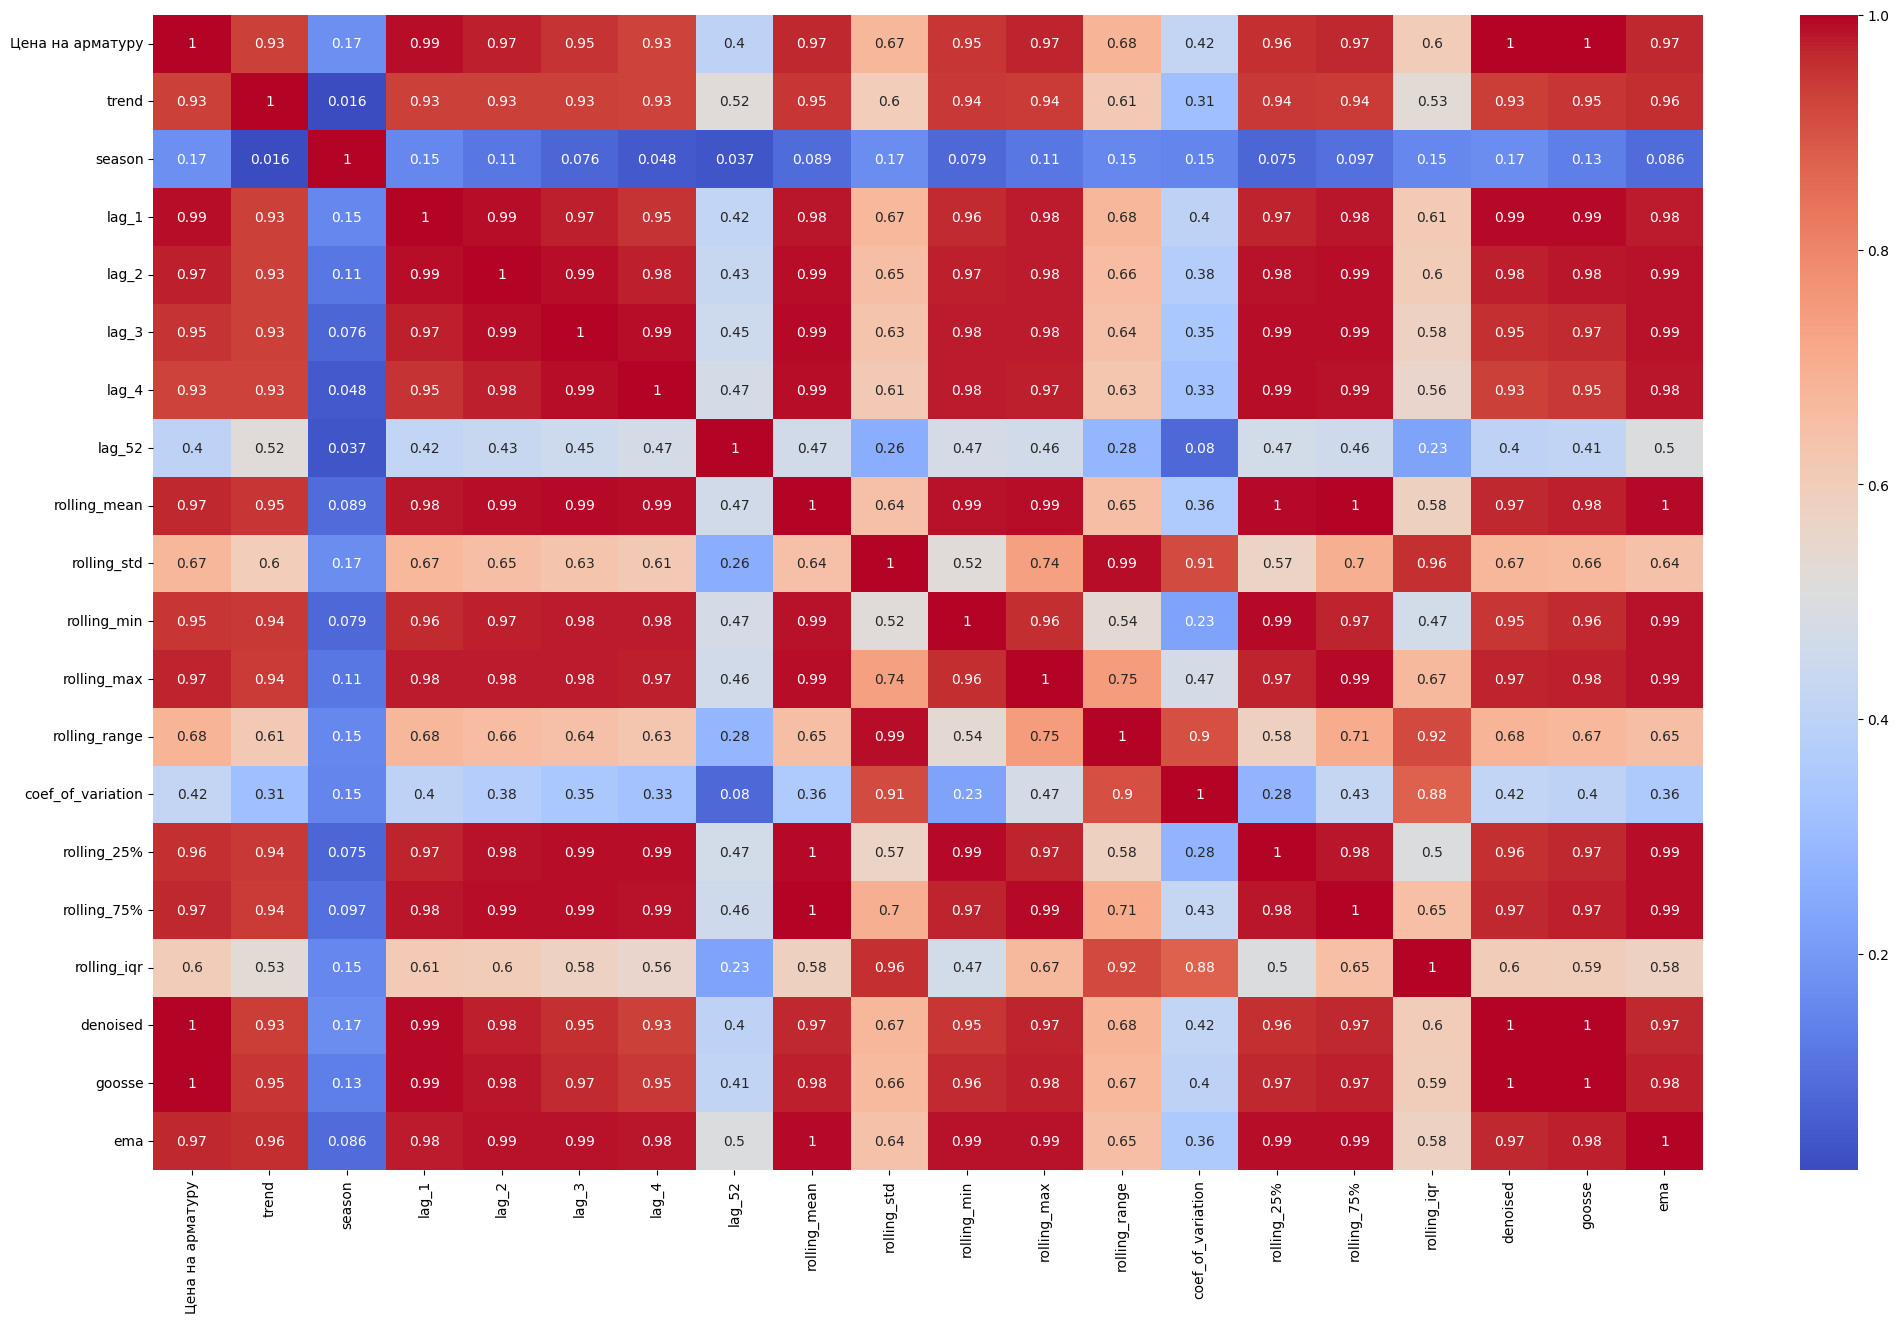

In [28]:
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Создаем модель LSTM

К сожалению, модель показывает не очень хорошие результаты

Хоть она и улавливает тренд и сезонность, но её предсказания недостаточно точные, и ошибаются на целых 3 тысячи рублей :(

*Хотя показатель R² равен 0.9444, что говорит о том, что модель в целом была бы не плохой, но возможно из-за того, что неправильно подобраны признаки (или их недостаточно), или параметры модели, или данных очень мало (всего 400 строчек), она работает не так хорошо как хотелось бы*

Вывод: лучше использовать другую модель

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - loss: 0.0371 - val_loss: 0.0889
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0055 - val_loss: 0.0314
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0036 - val_loss: 0.0202
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0033 - val_loss: 0.0197
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0039 - val_loss: 0.0203
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0026 - val_loss: 0.0159
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020 - val_loss: 0.0157
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0021 - val_loss: 0.0137
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0021 - val_loss: 0.0145
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0019 - val_loss: 0.0188
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0020 - val_

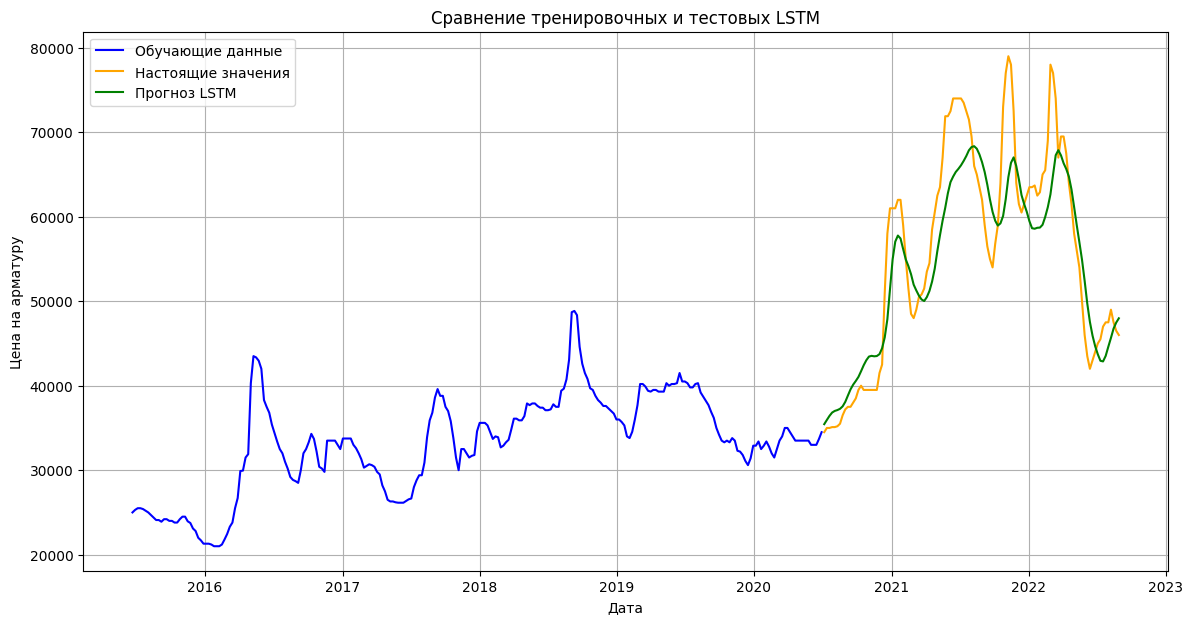

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import os
import random
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Bidirectional


seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

df.index = pd.to_datetime(df.index)


target = df['Цена на арматуру'].values.reshape(-1, 1)
features = df.drop(columns=['Цена на арматуру']).values

# масштабирование, чтобы модель работала корректно
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

target_scaled = scaler_target.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# объединяем целевую переменную и дополнительные признаки
data_scaled = np.hstack((target_scaled, features_scaled))

# Функция для создания датасета с временными шагами
def create_dataset(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :])  # все признаки
        y.append(data[i + timesteps, 0])  # целевая переменная
    return np.array(X), np.array(y)

# параметры
timesteps = 24  # кол. временных шагов
X, y = create_dataset(data_scaled, timesteps)


train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# преобразование данных в 3D-формат (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# model = Sequential()
# model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(32, return_sequences=False)))
# model.add(Dropout(0.3))
# model.add(Dense(1))

model = Sequential()

# Добавляем сверточный слой перед LSTM
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(timesteps, X_train.shape[2])))

# LSTM слои
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.3))

# Выходной слой
model.add(Dense(1))


# learning_rate = 0.005669387181782102
initial_learning_rate = 0.01
lr_schedule = tensorflow.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=1000, alpha=0.0001)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_learning_rate = 0.001
lr_schedule = tensorflow.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=1000, alpha=0.0001
)

optimizer = Adam(learning_rate=lr_schedule)  # Создаем Adam с CosineDecay

model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])  # Без ReduceLROnPlateau

# ПРОГНОЗ
y_pred_scaled = model.predict(X_test)

# Обратное преобразование масштаба данных
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# МЕТРИКИ
mse = mean_squared_error(y_test_original, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred)
print(f'R²: {r2:.4f}')

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(14, 7))
plt.plot(df.index[timesteps:train_size + timesteps], scaler_target.inverse_transform(y_train.reshape(-1, 1)), label='Обучающие данные', color='blue')
plt.plot(df.index[train_size + timesteps:], y_test_original, label='Настоящие значения', color='orange')
plt.plot(df.index[train_size + timesteps:], y_pred, label='Прогноз LSTM', color='green')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Сравнение тренировочных и тестовых LSTM')
plt.legend()
plt.grid()
plt.show()

Больше похоже на квадратный корень чем предсказание модели

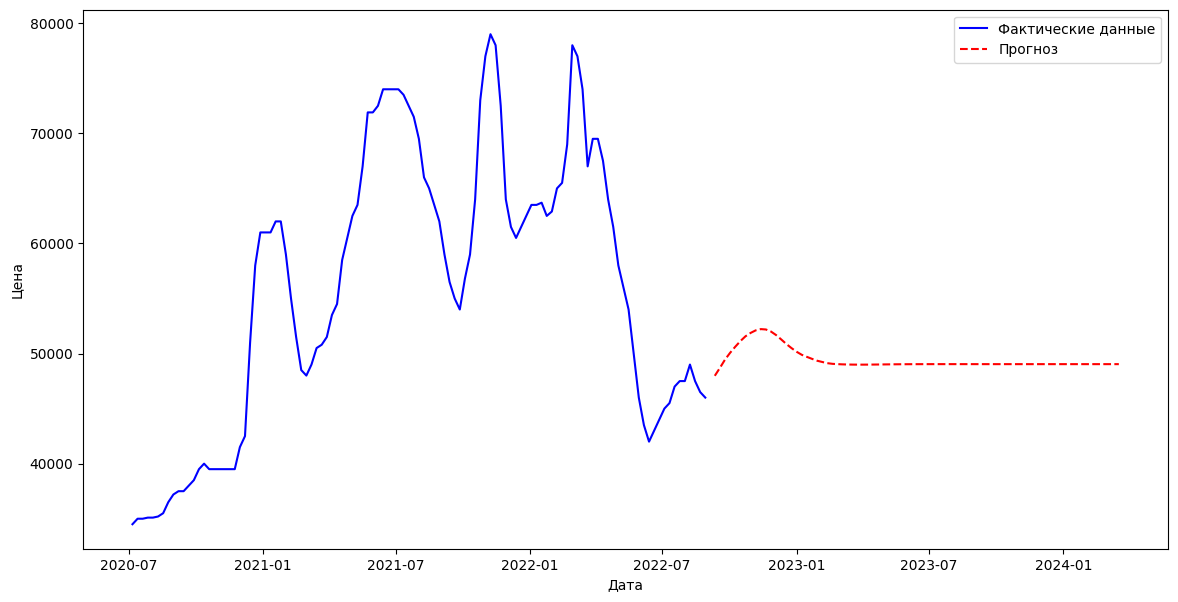

In [30]:
future_steps = 80
last_sequence = X_test[-1].copy()
forecast = []

for _ in range(future_steps):
    # Прогнозируем следующее значение
    next_pred_scaled = model.predict(last_sequence.reshape(1, timesteps, X_train.shape[2]), verbose=0)
    next_pred = scaler_target.inverse_transform(next_pred_scaled)

    # Ограничение, чтобы не было отрицательных значений
    next_pred = np.maximum(0, next_pred)

    forecast.append(next_pred[0, 0])

    # Обновляем последовательность (используем предсказанное значение и сохраняем старые признаки)
    next_features = last_sequence[1:]  # Берем все кроме первого шага
    next_pred_scaled_for_input = np.hstack((next_pred_scaled, last_sequence[-1, 1:].reshape(1, -1)))  # Добавляем старые признаки
    last_sequence = np.vstack((next_features, next_pred_scaled_for_input))

# Генерируем индексы для прогноза
forecast_dates = pd.date_range(df.index[-1], periods=future_steps + 1, freq='W')[1:]

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_original):], y_test_original, label="Фактические данные", color="blue")
plt.plot(forecast_dates, forecast, label="Прогноз", color="red", linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()


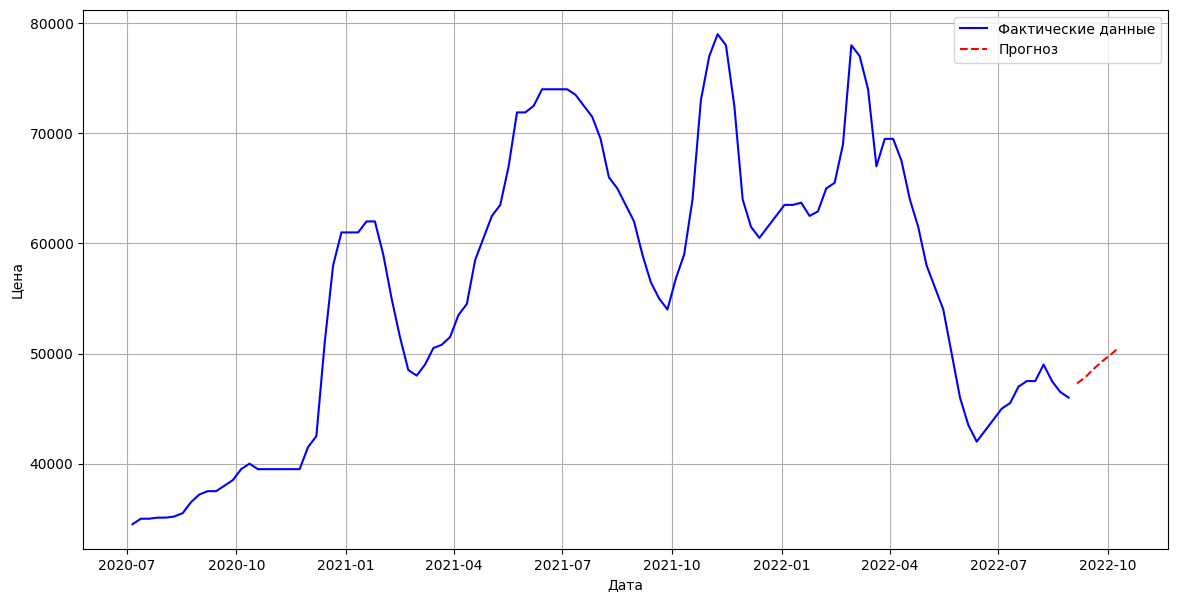

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

future_steps = 6
last_sequence = X_test[-1].copy()
forecast = []

for _ in range(future_steps):
    # Прогнозируем следующее значение
    next_pred_scaled = model.predict(last_sequence.reshape(1, timesteps, X_train.shape[2]), verbose=0)
    next_pred = scaler_target.inverse_transform(next_pred_scaled)

    # Ограничение, чтобы не было отрицательных значений
    next_pred = np.maximum(0, next_pred)

    forecast.append(next_pred[0, 0])

    # Обновляем последовательность (используем предсказанное значение и сохраняем старые признаки)
    next_features = last_sequence[1:]  # Берем все кроме первого шага
    next_pred_scaled_for_input = np.hstack((next_pred_scaled, last_sequence[-1, 1:].reshape(1, -1)))  # Добавляем старые признаки
    last_sequence = np.vstack((next_features, next_pred_scaled_for_input))

# 📌 Проверяем, является ли индекс временным рядом
if isinstance(df.index, pd.DatetimeIndex):
    last_date = df.index[-1]
else:
    last_date = pd.to_datetime('today')  # Берем текущую дату, если индексы не даты

# 🔹 Создаем даты прогноза
# 🔹 Создаем правильные даты прогноза (каждый понедельник)
forecast_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='W-MON')[1:]
last_date = df.index[-1]

# Генерируем прогнозные даты строго по понедельникам
forecast_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='W-MON')[1:]

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_original):], y_test_original, label="Фактические данные", color="blue")
plt.plot(forecast_dates, forecast, label="Прогноз", color="red", linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()


In [ ]:
forecast

[np.float32(47287.887),
 np.float32(47853.71),
 np.float32(48610.418),
 np.float32(49285.72),
 np.float32(49883.324),
 np.float32(50535.516)]

Сохраняем предсказания в таблицу

In [ ]:
lstm_forecast = model.predict(X_test)

# новый df с датами и предсказаниями
lstm_predictions = pd.DataFrame({
    "dt": df.index[train_size + timesteps:],  # даты
    "LSTM_Pred": y_pred.flatten()
})

# csv файл
lstm_predictions.to_csv("lstm_predictions.csv", index=False)
print("Файл lstm_predictions.csv сохранен!")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Файл lstm_predictions.csv сохранен!


In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pandas as pd
import pickle

# Загрузка модели
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Загрузка тестовых данных
test_data = pd.read_excel('/content/drive/MyDrive/ML_3/test.xlsx', parse_dates=['dt'])

# Прогнозирование для каждой даты
predictions = []

for date in test_data['dt']:
    # Прогноз на 6 недель вперед
    future_steps = 150
    last_sequence = X_test[-1]
    forecast = []

    for _ in range(future_steps):
      next_pred_scaled = model.predict(last_sequence.reshape(1, timesteps, X_train.shape[2]))
      next_pred = scaler_target.inverse_transform(next_pred_scaled)


      next_pred = np.maximum(0, next_pred)  #ограничение чтобы минус не предсказывала

      forecast.append(next_pred[0, 0])

    # обновление
      next_features = last_sequence[1:]
      next_pred_scaled_for_input = np.hstack((next_pred_scaled, np.zeros((1, X_train.shape[2] - 1))))
      last_sequence = np.vstack((next_features, next_pred_scaled_for_input))


    # Определение объема закупки
    if forecast[0] > forecast[-1]:  # Если цена растет
        n_weeks = 6
    else:  # Если цена снижается
        n_weeks = 1

    predictions.append(n_weeks)

# Добавление прогноза в тестовые данные
test_data['N_weeks'] = predictions

# Сохранение результатов
test_data.to_excel('test.xlsx', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

Сохраняем модель с её параметрами

In [32]:
import pickle
from tensorflow.keras.models import save_model


save_model(model, 'armature_price_model.h5')


with open('model.pkl', 'wb') as f:
    pickle.dump(scaler_target, f)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.2 MB/s eta 0:00:00


Подбираем лучшие параметры для модели

In [ ]:
import optuna

def objective(trial):
    # нужные гиперпараметры
    timesteps = trial.suggest_int("timesteps", 3, 14)
    lstm_units = trial.suggest_int("lstm_units", 32, 100)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 20, 100)
    lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)


    X, y = create_dataset(data_scaled, timesteps)
    train_size = int(len(X) * 0.6)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(timesteps, X_train.shape[2])),
        LSTM(lstm_units, return_sequences=False),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # прогноз
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # вычисление ошибки
    rmse = mean_squared_error(y_test_original, y_pred) ** 0.5
    return rmse

# оптимизация
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # кол. вариантов параметров


print("Лучшие параметры:", study.best_params)


[I 2025-03-23 10:24:28,022] A new study created in memory with name: no-name-562d4b9c-7a48-4015-8546-3e0fb66ec420
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-03-23 10:25:07,780] Trial 0 finished with value: 7236.461578009886 and parameters: {'timesteps': 12, 'lstm_units': 65, 'batch_size': 32, 'epochs': 37, 'learning_rate': 0.00021269900201150625}. Best is trial 0 with value: 7236.461578009886.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-03-23 10:25:28,374] Trial 1 finished with value: 8274.823685449612 and parameters: {'timesteps': 11, 'lstm_units': 33, 'batch_size': 32, 'epochs': 88, 'learning_rate': 0.006340988884397517}. Best is trial 0 with value: 7236.461578009886.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-03-23 10:25:36,920] Trial 2 finished with value: 6941.384610557483 and parameters: {'timesteps': 6, 'lstm_units': 35, 'batch_size': 64, 'epochs': 37, 'learning_rate': 0.005635294554694786}. Best is trial 2 with value: 6941.384610557483.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


[I 2025-03-23 10:25:49,096] Trial 3 finished with value: 7168.050613402426 and parameters: {'timesteps': 11, 'lstm_units': 83, 'batch_size': 64, 'epochs': 34, 'learning_rate': 0.00015416065624163458}. Best is trial 2 with value: 6941.384610557483.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-03-23 10:26:01,260] Trial 4 finished with value: 5986.793383179196 and parameters: {'timesteps': 6, 'lstm_units': 92, 'batch_size': 64, 'epochs': 45, 'learning_rate': 0.0012064453431243343}. Best is trial 4 with value: 5986.793383179196.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-03-23 10:26:15,371] Trial 5 finished with value: 5491.67792761793 and parameters: {'timesteps': 4, 'lstm_units': 85, 'batch_size': 32, 'epochs': 34, 'learning_rate': 0.0009828110047111617}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-03-23 10:26:35,623] Trial 6 finished with value: 6690.8970545154825 and parameters: {'timesteps': 12, 'lstm_units': 91, 'batch_size': 32, 'epochs': 40, 'learning_rate': 0.00021387132938170244}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2025-03-23 10:26:51,532] Trial 7 finished with value: 5535.7098472849675 and parameters: {'timesteps': 5, 'lstm_units': 85, 'batch_size': 64, 'epochs': 58, 'learning_rate': 0.0001604784607646624}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2025-03-23 10:27:16,666] Trial 8 finished with value: 6484.785415008177 and parameters: {'timesteps': 14, 'lstm_units': 85, 'batch_size': 32, 'epochs': 69, 'learning_rate': 0.0015785375843858367}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2025-03-23 10:27:47,048] Trial 9 finished with value: 8585.451881598772 and parameters: {'timesteps': 14, 'lstm_units': 41, 'batch_size': 16, 'epochs': 85, 'learning_rate': 0.0003361242481906589}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-03-23 10:28:03,510] Trial 10 finished with value: 5960.1375644261225 and parameters: {'timesteps': 3, 'lstm_units': 67, 'batch_size': 16, 'epochs': 60, 'learning_rate': 0.0006518407652597694}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


[I 2025-03-23 10:28:14,959] Trial 11 finished with value: 7109.53785803542 and parameters: {'timesteps': 3, 'lstm_units': 71, 'batch_size': 64, 'epochs': 58, 'learning_rate': 0.002034033071570397}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-03-23 10:28:24,581] Trial 12 finished with value: 5529.707546238298 and parameters: {'timesteps': 6, 'lstm_units': 99, 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0005361872245357013}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2025-03-23 10:28:36,147] Trial 13 finished with value: 6528.05362757661 and parameters: {'timesteps': 8, 'lstm_units': 100, 'batch_size': 32, 'epochs': 21, 'learning_rate': 0.0005370576201144222}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-03-23 10:28:44,934] Trial 14 finished with value: 7636.51136209871 and parameters: {'timesteps': 8, 'lstm_units': 100, 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.003059036171612665}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-03-23 10:28:54,138] Trial 15 finished with value: 5460.712576256488 and parameters: {'timesteps': 5, 'lstm_units': 74, 'batch_size': 32, 'epochs': 25, 'learning_rate': 0.0006952492034037124}. Best is trial 15 with value: 5460.712576256488.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-03-23 10:29:03,960] Trial 16 finished with value: 4291.118251885764 and parameters: {'timesteps': 4, 'lstm_units': 53, 'batch_size': 32, 'epochs': 31, 'learning_rate': 0.0008778716861087405}. Best is trial 16 with value: 4291.118251885764.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-03-23 10:29:17,496] Trial 17 finished with value: 3954.9069456645316 and parameters: {'timesteps': 5, 'lstm_units': 51, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.0028137691888126303}. Best is trial 17 with value: 3954.9069456645316.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-03-23 10:29:34,996] Trial 18 finished with value: 6451.246437942751 and parameters: {'timesteps': 9, 'lstm_units': 52, 'batch_size': 16, 'epochs': 49, 'learning_rate': 0.00315182163796065}. Best is trial 17 with value: 3954.9069456645316.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


[I 2025-03-23 10:30:00,957] Trial 19 finished with value: 5811.637737216615 and parameters: {'timesteps': 7, 'lstm_units': 54, 'batch_size': 16, 'epochs': 73, 'learning_rate': 0.009916183411349207}. Best is trial 17 with value: 3954.9069456645316.


Лучшие параметры: {'timesteps': 5, 'lstm_units': 51, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.0028137691888126303}


Проверяем работу модели на тестовых данных

In [ ]:
test_data = pd.read_excel('')

что-то нормальное

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import os
import random
import tensorflow



seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

df.index = pd.to_datetime(df.index)


target = df['Цена на арматуру'].values.reshape(-1, 1)
features = df.drop(columns=['Цена на арматуру']).values

# масштабирование, чтобы модель работала корректно
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

target_scaled = scaler_target.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# объединяем целевую переменную и дополнительные признаки
data_scaled = np.hstack((target_scaled, features_scaled))

# Функция для создания датасета с временными шагами
def create_dataset(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :])  # все признаки
        y.append(data[i + timesteps, 0])  # целевая переменная
    return np.array(X), np.array(y)

# параметры
timesteps = 12  # кол. временных шагов
X, y = create_dataset(data_scaled, timesteps)


train_size = int(len(X) * 0.6)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# преобразование данных в 3D-формат (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


model = Sequential()
model.add(LSTM(97, return_sequences=False, input_shape=(timesteps, X_train.shape[2])))  # Первый LSTM-слой
model.add(Dropout(0.3))
model.add(Dense(1))  # ыыходной слой



# learning_rate = 0.005669387181782102
learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# ОБУЧЕНИЕ
history = model.fit(X_train, y_train, epochs=49, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# ПРОГНОЗ
y_pred_scaled = model.predict(X_test)

# Обратное преобразование масштаба данных
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# МЕТРИКИ
mse = mean_squared_error(y_test_original, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred)
print(f'R²: {r2:.4f}')

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(14, 7))
plt.plot(df.index[timesteps:train_size + timesteps], scaler_target.inverse_transform(y_train.reshape(-1, 1)), label='Обучающие данные', color='blue')
plt.plot(df.index[train_size + timesteps:], y_test_original, label='Настоящие значения', color='orange')
plt.plot(df.index[train_size + timesteps:], y_pred, label='Прогноз LSTM', color='green')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Сравнение тренировочных и тестовых LSTM')
plt.legend()
plt.grid()
plt.show()